In [1]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
from IPython import display
from netCDF4 import Dataset
import datetime as dt
import numpy.ma as ma
from tensorflow.keras import layers
from keras import backend

/Users/jhudson/anaconda3/envs/ml_env/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
#Load In the Dataset
# The negative ones give an image shape of 24 x 48 which is easier to work with
ERA5_file = Dataset('/Users/jhudson/Documents/HW/FALL2023/ATS780/ATS780_Homework3/DATA/ERA5_u_v_relVort_200hPa_Colorado.nc')
ERA5_lats = ERA5_file.variables['latitude'][:-1]
ERA5_lons = ERA5_file.variables['longitude'][:-1]
ERA5_time = ERA5_file.variables['time'][:] #hours since 1900-01-01
ERA5_u = ma.getdata(ERA5_file.variables['u'][:,:-1,:-1])
ERA5_v = ma.getdata(ERA5_file.variables['v'][:,:-1,:-1])
ERA5_vort = ma.getdata(ERA5_file.variables['vo'][:,:-1,:-1])
ERA5_dates = np.array([dt.datetime(1900,1,1) + dt.timedelta(hours = int(t)) for t in ERA5_time])

In [3]:


def great_circle_distance(resolution:float = 1) -> tuple:
    '''
        Returns a 1d numpy array with the distance between degrees in
        the longitudinal direction in units of kilometers and the corresponding
        latitudes for those calculated great circle distances. The resolution
        sets the distance between the degree points, a resolution of 1 means
        every points is 1 degree apart
    '''

    lats = np.arange(-90,90+resolution,resolution)

    gcds = []
    for i in range(len(lats)):
        term_a = np.sin(np.deg2rad(lats[i]))*np.sin(np.deg2rad(lats[i]))
        term_b = np.cos(np.deg2rad(lats[i]))*np.cos(np.deg2rad(lats[i]))*np.cos(np.deg2rad(resolution))
        term_c = np.arccos(term_a + term_b)
        d = term_c * 6371.
        gcds.append(d)
    
    return np.array(gcds),lats

#now that I have that let's find a way to interpolate between lats to get the distance
#for a point of interest
def point_gcd_lon(point:tuple,resolution:int = 1) -> float:
    '''
        Given a point tuple (lon,lat) find the correspond longitude distance
        so I can convert from m to deg and return the distance for the points
        latitude. The return value is in kilometers.
    '''
    
    #get the lat for the point
    point_lat = point[1]
    #get the distances and lats for the great circle distance
    dists,lats = great_circle_distance(resolution=resolution)
    #check if the points latitude is already calculated
    if point_lat in lats:
        return dists[np.where(lats == point_lat)][0]
    #find the 2 lats closest to the points lat
    lat_differences = np.abs(lats - point_lat)
    #find the minimum and the second minimum through zip sort
    sorted_vals = sorted(zip(lat_differences,dists,lats))
    #now get the closest and 2nd closest distances/lats
    lat_closest = sorted_vals[0][2]
    lat_2nd_closest = sorted_vals[1][2]
    dist_closest = sorted_vals[0][1]
    dist_2nd_closest = sorted_vals[1][1]
    #now get the weighted average of the distance based on how close
    #the point is to the two latitude bands
    plc_dist = np.abs(lat_closest - point_lat)
    plc2_dist = np.abs(lat_2nd_closest - point_lat)

    weighted_dist = ((plc_dist/(plc_dist+plc2_dist)) * dist_closest) + ((plc2_dist/(plc_dist+plc2_dist))*dist_2nd_closest)

    return weighted_dist

#now that I can get dx and dy I can compute the numerical derivatives to use them with via numpy
def get_derivatives(field:np.ndarray,lats:np.ndarray,lons:np.ndarray) -> np.ndarray:
    '''
        Computes the derivative of a provided 2-d field that is of the form lat,lon. 
        
        Returns a 3-d array of the form lat,lon,2. At each point of the original 2d array
        is a 1-d matrix of the form (df/dx, df/dy)
    '''

    #make sure the field doesn't have any nans or bad values
    #and the bad values are set to zero (valid since there are no currents on land)
    nan_inds = np.where(field <= -9999)
    cleaned_field = np.copy(field)
    cleaned_field[nan_inds] = 0

    #get the dxs
    #first let's make an array of points to feed into the point_gcd_lon function
    #this returns dx in meters between points
    dx_1d = np.array([point_gcd_lon((0,lat),resolution=lons[1] - lons[0])*1000 for lat in lats])
    #this returns dy in meters between points
    dy_1d = np.array([(lats[1] - lats[0])*point_gcd_lon((0,0))*1000]*len(lats))
    #dx and dy are in meters for purposes of units
    #turn them into 2d fields to match the field of interest
    dx_field = np.empty(field.shape)
    dy_field = np.empty(field.shape)
    for i in range(dx_field.shape[1]):
        dx_field[:,i] = dx_1d
        dy_field[:,i] = dy_1d
    #now let's calculate the df/dx and df/dy fields using finite differences
    dfdx_field = np.empty(cleaned_field.shape)
    dfdy_field = np.empty(cleaned_field.shape)
    #first do the interiors then the edges
    #array is set up such that rows are ys and columns are xs
    #first do the interiors
    dfdx_field[:,1:-1] = (cleaned_field[:,2:] - cleaned_field[:,:-2])
    dfdx_field[:,1:-1] = dfdx_field[:,1:-1] / (dx_field[:,1:-1] * 2.0)
    dfdy_field[1:-1,:] = (cleaned_field[2:,:] - cleaned_field[:-2,:])
    dfdy_field[1:-1,:] = dfdy_field[1:-1,:] / (dy_field[1:-1,:] * 2.0)
    #now let's do the edges
    #first the left/west edge of dfdx
    dfdx_field[:,0] = (cleaned_field[:,0] - cleaned_field[:,1]) / (dx_field[:,0] * 2.0)
    #next the right/east edge of dfdx
    dfdx_field[:,-1] = (cleaned_field[:,-2] - cleaned_field[:,-1]) / (dx_field[:,-1] * 2.0)
    #now the top/north edge of dfdy
    dfdy_field[0,:] = (cleaned_field[0,:] - cleaned_field[1,:]) / (dy_field[0,:] * 2.0)
    #now the bottem edge
    dfdy_field[-1,:] = (cleaned_field[-2,:] - cleaned_field[-1,:]) / (dy_field[-1,:] * 2.0)

    dfdx_field[nan_inds] = np.nan
    dfdy_field[nan_inds] = np.nan

    return dfdx_field,dfdy_field

def calculate_relvort(u,v,lat,lon):
    # now that I can get the derivatives let's get them for each day for both the U and V fields
    dudx,dudy = get_derivatives(u,lat,lon)
    dvdx,dvdy = get_derivatives(v,lat,lon)
    
    return dvdx - dudy

In [4]:
# now let's normalize the three fields
def normalize_dataset(data:np.ndarray):
    data_min = np.nanmin(data)
    data_max = np.nanmax(data)

    norm_data = (data - data_min) / (data_max - data_min)

    return norm_data,data_max,data_min

def norm_w_maxmin(data,max,min):
    
    return (data - min) / (max - min)

def denormalize_data(norm_data:np.ndarray,data_max:float,data_min:float):
    denormed_data = norm_data * (data_max - data_min) + data_min

    return denormed_data

norm_u,u_max,u_min = normalize_dataset(ERA5_u)
norm_v,v_max,v_min = normalize_dataset(ERA5_v)
norm_vo,vo_max,vo_min = normalize_dataset(ERA5_vort)

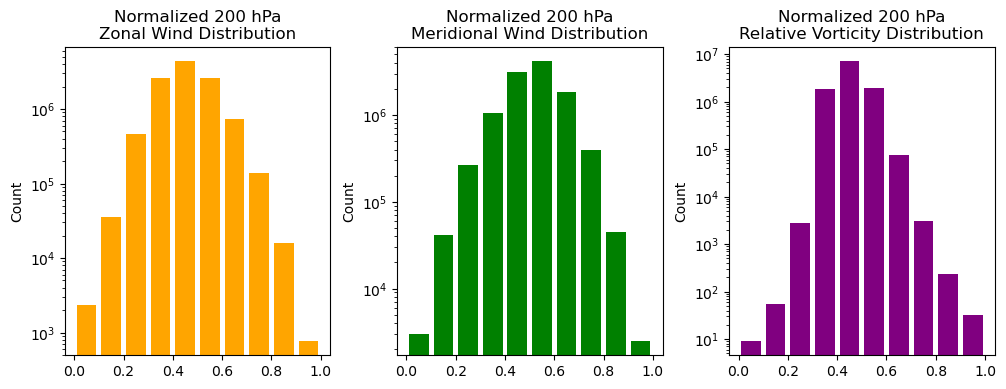

In [62]:
fit, ax = plt.subplots(1,3,figsize = (12,4))

ax[0].hist(norm_u.flatten(),color = 'orange',rwidth = 0.8)
ax[0].set_title("Normalized 200 hPa\nZonal Wind Distribution")
ax[0].set_yscale('log')
ax[0].set_ylabel('Count')

ax[1].hist(norm_v.flatten(),color = 'green',rwidth = 0.8)
ax[1].set_title("Normalized 200 hPa\nMeridional Wind Distribution")
ax[1].set_yscale('log')
ax[1].set_ylabel('Count')

ax[2].hist(norm_vo.flatten(),color = 'purple',rwidth = 0.8)
ax[2].set_title("Normalized 200 hPa\nRelative Vorticity Distribution")
ax[2].set_yscale('log')
ax[2].set_ylabel('Count')

plt.subplots_adjust(wspace = 0.25)

plt.savefig('/Users/jhudson/Documents/HW/FALL2023/ATS780/ATS780_Homework3/FIGURES/data_distribution.png',dpi = 400,bbox_inches='tight')

plt.show()

In [6]:
# combine the 3 values together to make a 3 channel 'image'
combined_array = np.empty((len(ERA5_dates),norm_u.shape[1],norm_u.shape[2],3))
combined_array[:,:,:,0] = norm_u[:]
combined_array[:,:,:,1] = norm_v[:]
combined_array[:,:,:,2] = norm_vo[:]
print(combined_array.shape)

(9496, 24, 48, 3)


In [7]:
# Set the Seed and Batch/Shuffle the data
RAND_SEED = 144
BUFFER_SIZE = int(combined_array.shape[0])
BATCH_SIZE = 64
tf.random.set_seed(RAND_SEED)
training_data = tf.data.Dataset.from_tensor_slices(combined_array).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

2023-12-13 12:15:01.982565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


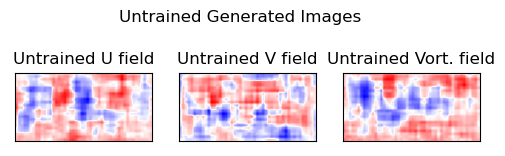

In [63]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(3*6*128, use_bias = False, input_shape = (24*48,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((3,6,128)))
    assert model.output_shape == (None,3,6,128)

    model.add(layers.Conv2DTranspose(16, (3,3), strides = (1,1), padding = 'same', use_bias = False))
    assert model.output_shape == (None,3,6,16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D(size = (2,2)))

    model.add(layers.Conv2DTranspose(32, (3,3), strides = (1,1), padding = 'same', use_bias = False))
    assert model.output_shape == (None,6,12,32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D(size = (2,2)))

    model.add(layers.Conv2DTranspose(64, (3,3), strides = (1,1), padding = 'same', use_bias = False))
    assert model.output_shape == (None,12,24,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    
    model.add(layers.UpSampling2D(size = (2,2)))

    model.add(layers.Conv2D(3, (3,3), strides = (1,1), padding = 'same', use_bias = False,activation = 'tanh'))
    assert model.output_shape == (None,24,48,3)

    model.compile(loss = wasserstein_loss)

    return model

generator = generator_model()

noise = tf.random.normal([1,24*48])
generated_image = generator(noise, training = False)

fig,ax = plt.subplots(1,3,figsize = (6,2))

ax[0].imshow(generated_image[0,:,:,0],cmap = 'bwr')
ax[0].set_title('Untrained U field')

ax[1].imshow(generated_image[0,:,:,1],cmap = 'bwr')
ax[1].set_title('Untrained V field')

ax[2].imshow(generated_image[0,:,:,2],cmap = 'bwr')
ax[2].set_title('Untrained Vort. field')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.suptitle('Untrained Generated Images')

plt.savefig('/Users/jhudson/Documents/HW/FALL2023/ATS780/ATS780_Homework3/FIGURES/untrained_gan_output.png',dpi = 300,bbox_inches = 'tight')

plt.show()




In [9]:
def discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3,3), strides = (1,1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(32, (3,3), strides = (1,1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(32, (3,3), strides = (1,1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.compile()

    return model

discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision.numpy()[0][0])



-0.00013673482


In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

def rv_mse(generated_image_batch):
    batch_calc_rv = np.empty((generated_image_batch.shape[0],generated_image_batch.shape[1],generated_image_batch.shape[2]))
    for i in range(generated_image_batch.shape[0]):
        denorm_u_predict = denormalize_data(generated_image_batch[i,:,:,0],u_max,u_min)
        denorm_v_predict = denormalize_data(generated_image_batch[i,:,:,1],v_max,v_min)
        calc_rv = calculate_relvort(denorm_u_predict,denorm_v_predict,ERA5_lats,ERA5_lons)
        calc_rv_norm = norm_w_maxmin(calc_rv,vo_max,vo_min)
        batch_calc_rv[i,:,:] = calc_rv_norm
    
    batch_mse = (1./generated_image_batch.shape[0]) * np.sum((batch_calc_rv - generated_image_batch[:,:,:,2])**2)

    return batch_mse

    
    




In [11]:
generator_optimizer = tf.keras.optimizers.Adam(5e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-4)

In [12]:
noise_dim = 24*48
num_examples_to_generate = 4
seed = tf.random.normal([num_examples_to_generate,noise_dim])

In [13]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      generated_images = (generated_images + 1) / 2 #converts from [-1,1] to [0,1]

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [14]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  print(f'Pre-conversion max: {np.max(predictions):.03f}, min: {np.min(predictions):.03f}')

  predictions = (predictions + 1) / 2 #converts from [-1,1] to [0,1]

  print(f'Post-conversion max: {np.max(predictions):.03f}, min: {np.min(predictions):.03f}')

  print(predictions.shape)

  fig,ax = plt.subplots(num_examples_to_generate,4,figsize=(14, 8))

  for i in range(num_examples_to_generate):
    ax[i,0].imshow(predictions[i,:,:,0],cmap = 'bwr')
    ax[i,0].set_title('U-field')
    ax[i,1].imshow(predictions[i,:,:,1],cmap = 'bwr')
    ax[i,1].set_title('V-field')
    ax[i,2].imshow(predictions[i,:,:,2],cmap = 'bwr')
    ax[i,2].set_title('Rel. Vort.-field')
    denorm_u_predict = denormalize_data(predictions[i,:,:,0],u_max,u_min)
    denorm_v_predict = denormalize_data(predictions[i,:,:,1],v_max,v_min)
    calc_rv = calculate_relvort(denorm_u_predict,denorm_v_predict,ERA5_lats,ERA5_lons)
    calc_rv_norm = norm_w_maxmin(calc_rv,vo_max,vo_min)
    ax[i,3].imshow(calc_rv_norm,cmap = 'bwr')
    ax[i,3].set_title('Calculated RV field')
  
  for row in ax:
    for item in row:
      item.set_xticks([])
      item.set_yticks([])
  
  plt.suptitle(f'Epoch {epoch} Training Examples')

  plt.savefig('/Users/jhudson/Documents/HW/FALL2023/ATS780/ATS780_Homework3/FIGURES/EPOCH_IMS/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
  

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  
  

Pre-conversion max: 0.428, min: -0.330
Post-conversion max: 0.714, min: 0.335
(4, 24, 48, 3)


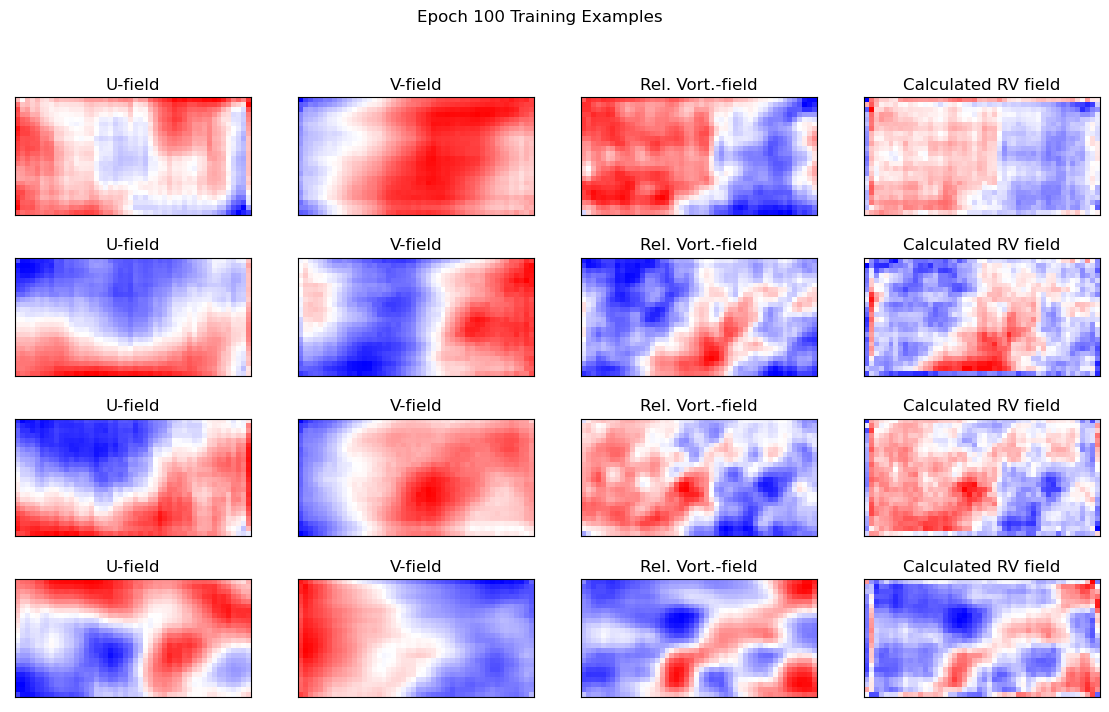

In [16]:
EPOCHS = 100
train(training_data, EPOCHS)

In [44]:
initial_noise = tf.random.normal([1,24*48]).numpy()

print(initial_noise.shape)
initial_noise_input = tf.convert_to_tensor(initial_noise)

initial_noise = np.reshape(initial_noise[0],(24,48))

in_noise_image = generator(initial_noise_input,training = False)
in_noise_image = (in_noise_image + 1) / 2

test_noise3 = np.empty((48,24*48))

for i in range(48):
    copy_noise = np.copy(initial_noise)
    copy_noise[:,i] = 10
    test_noise3[i,:] = np.copy(copy_noise.flatten())


plot_noise3 = np.copy(test_noise3)
test_noise3 = tf.convert_to_tensor(test_noise3)

generated_image = generator(test_noise3, training = False)

generated_image = (generated_image + 1) / 2

for i in range(48):

    fig,ax = plt.subplots(2,5,figsize=(14, 4))

    ax[0,0].imshow(np.reshape(initial_noise,(24,48)))
    ax[0,0].set_title('Original Input Noise')
    ax[0,1].imshow(in_noise_image[0,:,:,0],cmap = 'bwr')
    ax[0,1].set_title('U-field')
    ax[0,2].imshow(in_noise_image[0,:,:,1],cmap = 'bwr')
    ax[0,2].set_title('V-field')
    ax[0,3].imshow(in_noise_image[0,:,:,2],cmap = 'bwr')
    ax[0,3].set_title('Rel. Vort.-field')
    denorm_u_predict = denormalize_data(in_noise_image[0,:,:,0],u_max,u_min)
    denorm_v_predict = denormalize_data(in_noise_image[0,:,:,1],v_max,v_min)
    calc_rv = calculate_relvort(denorm_u_predict,denorm_v_predict,ERA5_lats,ERA5_lons)
    calc_rv_norm = norm_w_maxmin(calc_rv,vo_max,vo_min)
    ax[0,4].imshow(calc_rv_norm,cmap = 'bwr')
    ax[0,4].set_title('Calculated RV field')

    ax[1,0].imshow(np.reshape(plot_noise3[i],(24,48)))
    ax[1,0].set_title('Modified Input Noise')
    ax[1,1].imshow(generated_image[i,:,:,0],cmap = 'bwr')
    ax[1,1].set_title('U-field')
    ax[1,2].imshow(generated_image[i,:,:,1],cmap = 'bwr')
    ax[1,2].set_title('V-field')
    ax[1,3].imshow(generated_image[i,:,:,2],cmap = 'bwr')
    ax[1,3].set_title('Rel. Vort.-field')
    denorm_u_predict = denormalize_data(generated_image[i,:,:,0],u_max,u_min)
    denorm_v_predict = denormalize_data(generated_image[i,:,:,1],v_max,v_min)
    calc_rv = calculate_relvort(denorm_u_predict,denorm_v_predict,ERA5_lats,ERA5_lons)
    calc_rv_norm = norm_w_maxmin(calc_rv,vo_max,vo_min)
    ax[1,4].imshow(calc_rv_norm,cmap = 'bwr')
    ax[1,4].set_title('Calculated RV field')

    for row in ax:
        for col in row:
            col.set_xticks([])
            col.set_yticks([])

    plt.suptitle("Noise Modification Experiment")

    plt.savefig(f'/Users/jhudson/Documents/HW/FALL2023/ATS780/ATS780_Homework3/FIGURES/NOISE_EXP/COL_MOD/COL_MOD_{i:04d}.png',dpi = 200,bbox_inches = 'tight')
    plt.cla()
    plt.clf()
    plt.close()

(1, 1152)


In [45]:
initial_noise = tf.random.normal([1,24*48]).numpy()

print(initial_noise.shape)
initial_noise_input = tf.convert_to_tensor(initial_noise)

initial_noise = np.reshape(initial_noise[0],(24,48))

in_noise_image = generator(initial_noise_input,training = False)
in_noise_image = (in_noise_image + 1) / 2

test_noise3 = np.empty((24,24*48))

for i in range(24):
    copy_noise = np.copy(initial_noise)
    copy_noise[i,:] = 10
    test_noise3[i,:] = np.copy(copy_noise.flatten())


plot_noise3 = np.copy(test_noise3)
test_noise3 = tf.convert_to_tensor(test_noise3)

generated_image = generator(test_noise3, training = False)

generated_image = (generated_image + 1) / 2

for i in range(24):

    fig,ax = plt.subplots(2,5,figsize=(14, 4))

    ax[0,0].imshow(np.reshape(initial_noise,(24,48)))
    ax[0,0].set_title('Original Input Noise')
    ax[0,1].imshow(in_noise_image[0,:,:,0],cmap = 'bwr')
    ax[0,1].set_title('U-field')
    ax[0,2].imshow(in_noise_image[0,:,:,1],cmap = 'bwr')
    ax[0,2].set_title('V-field')
    ax[0,3].imshow(in_noise_image[0,:,:,2],cmap = 'bwr')
    ax[0,3].set_title('Rel. Vort.-field')
    denorm_u_predict = denormalize_data(in_noise_image[0,:,:,0],u_max,u_min)
    denorm_v_predict = denormalize_data(in_noise_image[0,:,:,1],v_max,v_min)
    calc_rv = calculate_relvort(denorm_u_predict,denorm_v_predict,ERA5_lats,ERA5_lons)
    calc_rv_norm = norm_w_maxmin(calc_rv,vo_max,vo_min)
    ax[0,4].imshow(calc_rv_norm,cmap = 'bwr')
    ax[0,4].set_title('Calculated RV field')

    ax[1,0].imshow(np.reshape(plot_noise3[i],(24,48)))
    ax[1,0].set_title('Modified Input Noise')
    ax[1,1].imshow(generated_image[i,:,:,0],cmap = 'bwr')
    ax[1,1].set_title('U-field')
    ax[1,2].imshow(generated_image[i,:,:,1],cmap = 'bwr')
    ax[1,2].set_title('V-field')
    ax[1,3].imshow(generated_image[i,:,:,2],cmap = 'bwr')
    ax[1,3].set_title('Rel. Vort.-field')
    denorm_u_predict = denormalize_data(generated_image[i,:,:,0],u_max,u_min)
    denorm_v_predict = denormalize_data(generated_image[i,:,:,1],v_max,v_min)
    calc_rv = calculate_relvort(denorm_u_predict,denorm_v_predict,ERA5_lats,ERA5_lons)
    calc_rv_norm = norm_w_maxmin(calc_rv,vo_max,vo_min)
    ax[1,4].imshow(calc_rv_norm,cmap = 'bwr')
    ax[1,4].set_title('Calculated RV field')

    for row in ax:
        for col in row:
            col.set_xticks([])
            col.set_yticks([])

    plt.suptitle("Noise Modification Experiment")

    plt.savefig(f'/Users/jhudson/Documents/HW/FALL2023/ATS780/ATS780_Homework3/FIGURES/NOISE_EXP/ROW_MOD/ROW_MOD_{i:04d}.png',dpi = 100,bbox_inches = 'tight')
    plt.cla()
    plt.clf()
    plt.close()

(1, 1152)


In [52]:
initial_noise = tf.random.normal([1,24*48]).numpy()

print(initial_noise.shape)
initial_noise_input = tf.convert_to_tensor(initial_noise)

initial_noise = np.reshape(initial_noise[0],(24,48))

in_noise_image = generator(initial_noise_input,training = False)
in_noise_image = (in_noise_image + 1) / 2

test_noise3 = np.empty((24*48,24*48))

mod_ind = 0
for i in range(24):
    for j in range(48):
        copy_noise = np.copy(initial_noise)
        copy_noise[i,j] = 10
        test_noise3[mod_ind,:] = np.copy(copy_noise.flatten())
        mod_ind+=1


plot_noise3 = np.copy(test_noise3)
test_noise3 = tf.convert_to_tensor(test_noise3)

generated_image = generator(test_noise3, training = False)

generated_image = (generated_image + 1) / 2

print(plot_noise3.shape)
print(test_noise3.shape)
print(generated_image.shape)

for i in range(24*48):

    fig,ax = plt.subplots(2,5,figsize=(14, 4))

    ax[0,0].imshow(np.reshape(initial_noise,(24,48)))
    ax[0,0].set_title('Original Input Noise')
    ax[0,1].imshow(in_noise_image[0,:,:,0],cmap = 'bwr')
    ax[0,1].set_title('U-field')
    ax[0,2].imshow(in_noise_image[0,:,:,1],cmap = 'bwr')
    ax[0,2].set_title('V-field')
    ax[0,3].imshow(in_noise_image[0,:,:,2],cmap = 'bwr')
    ax[0,3].set_title('Rel. Vort.-field')
    denorm_u_predict = denormalize_data(in_noise_image[0,:,:,0],u_max,u_min)
    denorm_v_predict = denormalize_data(in_noise_image[0,:,:,1],v_max,v_min)
    calc_rv = calculate_relvort(denorm_u_predict,denorm_v_predict,ERA5_lats,ERA5_lons)
    calc_rv_norm = norm_w_maxmin(calc_rv,vo_max,vo_min)
    ax[0,4].imshow(calc_rv_norm,cmap = 'bwr')
    ax[0,4].set_title('Calculated RV field')

    ax[1,0].imshow(np.reshape(plot_noise3[i],(24,48)))
    ax[1,0].set_title('Modified Input Noise')
    ax[1,1].imshow(generated_image[i,:,:,0],cmap = 'bwr')
    ax[1,1].set_title('U-field')
    ax[1,2].imshow(generated_image[i,:,:,1],cmap = 'bwr')
    ax[1,2].set_title('V-field')
    ax[1,3].imshow(generated_image[i,:,:,2],cmap = 'bwr')
    ax[1,3].set_title('Rel. Vort.-field')
    denorm_u_predict = denormalize_data(generated_image[i,:,:,0],u_max,u_min)
    denorm_v_predict = denormalize_data(generated_image[i,:,:,1],v_max,v_min)
    calc_rv = calculate_relvort(denorm_u_predict,denorm_v_predict,ERA5_lats,ERA5_lons)
    calc_rv_norm = norm_w_maxmin(calc_rv,vo_max,vo_min)
    ax[1,4].imshow(calc_rv_norm,cmap = 'bwr')
    ax[1,4].set_title('Calculated RV field')

    for row in ax:
        for col in row:
            col.set_xticks([])
            col.set_yticks([])

    plt.suptitle("Noise Modification Experiment")

    plt.savefig(f'/Users/jhudson/Documents/HW/FALL2023/ATS780/ATS780_Homework3/FIGURES/NOISE_EXP/PIXEL_MOD/PIXEL_MOD_{i:04d}.png',dpi = 100,bbox_inches = 'tight')
    plt.cla()
    plt.clf()
    plt.close()

(1, 1152)
(1152, 1152)
(1152, 1152)
(1152, 24, 48, 3)


In [61]:
def gif_maker(directory,filename,frame_duration):
    os.chdir(directory)
    import glob
    img_files = sorted(glob.glob('*.png'))
    imgs = [Image.open(im) for im in img_files]

    imgs[0].save(filename,format='GIF',save_all=True,duration = frame_duration,append_images=imgs[1:])

    return None

col_dir = '/Users/jhudson/Documents/HW/FALL2023/ATS780/ATS780_Homework3/FIGURES/NOISE_EXP/COL_MOD'
row_dir = '/Users/jhudson/Documents/HW/FALL2023/ATS780/ATS780_Homework3/FIGURES/NOISE_EXP/ROW_MOD'
pix_dir = '/Users/jhudson/Documents/HW/FALL2023/ATS780/ATS780_Homework3/FIGURES/NOISE_EXP/PIXEL_MOD'
train_dir = '/Users/jhudson/Documents/HW/FALL2023/ATS780/ATS780_Homework3/FIGURES/EPOCH_IMS'

duration = 250

gif_maker(col_dir,'COLUMN_MOD.gif',duration)
gif_maker(row_dir,'ROW_MOD.gif',duration)
gif_maker(pix_dir,'PIXEL_MOD.gif',duration)
gif_maker(train_dir,'TRAINING_GIF.gif',duration)

1/1 [==============================] - 0s 48ms/step


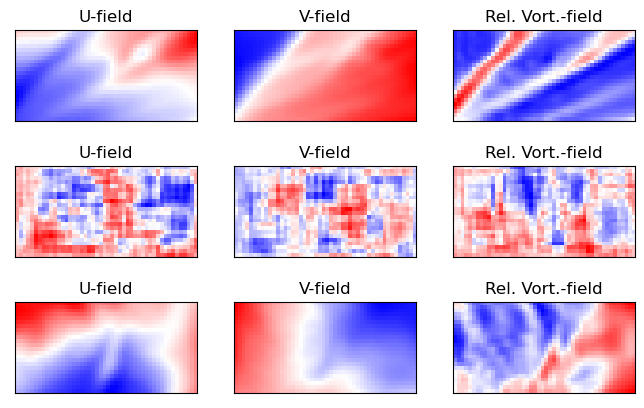

In [87]:
initial_noise = tf.random.normal([12,24*48])

generated_image = generator.predict(initial_noise)
generated_image = (generated_image + 1) / 2

era5_image1 = combined_array[300,:,:,:]

era5_image2 = combined_array[8000,:,:,:]

fig,ax = plt.subplots(3,3,figsize = (8,5))

ax[0,0].imshow(era5_image1[:,:,0],cmap = 'bwr')
ax[0,0].set_title('U-field')
ax[0,1].imshow(era5_image1[:,:,1],cmap = 'bwr')
ax[0,1].set_title('V-field')
ax[0,2].imshow(era5_image1[:,:,2],cmap = 'bwr')
ax[0,2].set_title('Rel. Vort.-field')

ax[1,0].imshow(generated_image[-1,:,:,0],cmap = 'bwr')
ax[1,0].set_title('U-field')
ax[1,1].imshow(generated_image[-1,:,:,1],cmap = 'bwr')
ax[1,1].set_title('V-field')
ax[1,2].imshow(generated_image[-1,:,:,2],cmap = 'bwr')
ax[1,2].set_title('Rel. Vort.-field')

ax[2,0].imshow(era5_image2[:,:,0],cmap = 'bwr')
ax[2,0].set_title('U-field')
ax[2,1].imshow(era5_image2[:,:,1],cmap = 'bwr')
ax[2,1].set_title('V-field')
ax[2,2].imshow(era5_image2[:,:,2],cmap = 'bwr')
ax[2,2].set_title('Rel. Vort.-field')

for row in ax:
    for col in row:
        col.set_xticks([])
        col.set_yticks([])

plt.show()


